#Finetuning Wav2Vec2 using Common Voice Data

This training script was executed in Colab using the L4 configuration with a GPU having 22.5GB of memory. Due to time and computational resource constraints, the final model was trained using 100,000 samples (approximately 50% of the total data) for 10,000 steps with a batch size of 16 over a period of 7 hours. The resulting word error rate (WER) is **0.08** for the `cv-valid-dev` set and **0.077** for the `cv-valid-test` set.



In [1]:
!pip install datasets
!pip install transformers
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.2 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 51.9 MB/

The training checkpoints are directly uploaded to the HuggingFace Hub during training.

In [2]:
from huggingface_hub import notebook_login

notebook_login()

##Prepare Data, Tokenizer, Feature Extractor

ASR models convert speech into text using a feature extractor to process the speech signal into a suitable input format and a tokenizer to convert the model's output into text. In the Transformers library, the Wav2Vec2 model includes a tokenizer called Wav2Vec2CTCTokenizer and a feature extractor named Wav2Vec2FeatureExtractor. The next step is to create the tokenizer that will decode the model's predictions.

###Create Wav2Vec2CTCTokenizer

The pretrained Wav2Vec2 checkpoint converts speech signals into context representations, which must be mapped to transcriptions in a fine-tuned model by adding a linear layer on top of the transformer block. This linear layer classifies each context representation into token classes. The output size of this layer is determined by the vocabulary from the labeled dataset used for fine-tuning, and the initial step involves defining a vocabulary based on the CommonVoice dataset's transcriptions.

For convinience, I have uploaded the Common Voice dataset to my Huggingface repo: https://huggingface.co/nightraider as private dataset.

In [ ]:
from datasets import load_dataset, load_metric, Audio

cv = load_dataset("nightraider/cv_train", token=True)

Due to limitation in compute resource, only 100,000 samples (~50% of all data) were used for finetuning the `wav2vec2-large-960h-cv` model.


In [4]:
cv["train"] = cv["train"].select(range(10000))  # for quick experimentation
# cv["train"] = cv["train"].select(range(100000)) # Used for training wav2vec2-large-960h-cv

Remove uncessary columns in data.


In [5]:
cv = cv.remove_columns(['up_votes', 'down_votes', 'age', 'gender', 'accent', 'duration'])

Resample audio to 16kHz for training Wav2Vec2 models.

In [6]:
cv = cv.cast_column("audio", Audio(sampling_rate=16000))

As requested in Task 3a, the dataset is split as 70% for training and 30% for validation.

In [7]:
ds = cv['train'].train_test_split(test_size=0.3)
ds

DatasetDict({
    train: Dataset({
        features: ['audio', 'text'],
        num_rows: 7000
    })
    test: Dataset({
        features: ['audio', 'text'],
        num_rows: 3000
    })
})

In [8]:
# Function for display some random samples in dataset
from datasets import ClassLabel
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    display(HTML(df.to_html()))

In [9]:
show_random_elements(ds["train"].remove_columns(["audio"]), num_examples=10)

,text
0,especially with an election coming up in a few days
1,the determinant is the product of all eigenvectors of a matrix
2,that's why i feel that i deserve a part of what you find
3,the boy looked out at the horizon
4,few people realise the immensity of vacancy
5,where have you been
6,in any case the desert was impassable
7,people saw me coming and welcomed me he thought
8,you're a smart young woman
9,throughout the night the boy dug at the place he had chosen but found nothing


Next we normalize the text by removing any special characters and lowercase the text.

In [10]:
import re
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"]'

def remove_special_characters(batch):
    batch["text"] = re.sub(chars_to_ignore_regex, '', batch["text"]).lower() + " "
    return batch

In [11]:
ds = ds.map(remove_special_characters)

Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Let's extract all distinct letters of the training and test data and build our vocabulary from this set of letters.
The mapping function concatenates all transcriptions into one long transcription and then transforms the string into a set of chars.

In [12]:
def extract_all_chars(batch):
  all_text = " ".join(batch["text"])
  vocab = list(set(all_text))
  return {"vocab": [vocab], "all_text": [all_text]}

In [13]:
vocabs = ds.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=ds.column_names["train"])

Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Now, we create the union of all distinct letters in the training dataset and test dataset and convert the resulting list into an enumerated dictionary.

In [14]:
vocab_list = list(set(vocabs["train"]["vocab"][0]) | set(vocabs["test"]["vocab"][0]))

In [ ]:
vocab_dict = {v: k for k, v in enumerate(vocab_list)}
vocab_dict

To make it easier to identify the space character as a distinct token, we represent it with a more noticeable character: '|'. We also add an "unknown" token to allow the model to handle characters that were not present in the training data. Additionally, we include a padding token that corresponds to the "blank token" used in the CTC algorithm, which is a crucial component of this technique.

In [16]:
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

In [17]:
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
len(vocab_dict)

30

Save the vocabulary as a json file.

In [18]:
import json
with open('vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

In a final step, we use the json file to instantiate an object of the Wav2Vec2CTCTokenizer class.

In [19]:
from transformers import Wav2Vec2CTCTokenizer

tokenizer = Wav2Vec2CTCTokenizer("./vocab.json", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")

Upload the tokenizer to the Hub for reusing with the fine-tuned model.

In [20]:
repo_name = "wav2vec2-base-cv-demo-google-colab"  # for quick experimentation
# repo_name = "wav2vec2-large-960h-cv"

tokenizer.push_to_hub(repo_name)

README.md:   0%|          | 0.00/1.49k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/nightraider/wav2vec2-base-cv-demo-google-colab/commit/005bc2deea2526dd375ee95ba02d5e2865141bb2', commit_message='Upload tokenizer', commit_description='', oid='005bc2deea2526dd375ee95ba02d5e2865141bb2', pr_url=None, pr_revision=None, pr_num=None)

###Create Wav2Vec2 Feature Extractor

A Wav2Vec2 feature extractor object requires the following parameters to be instantiated:

- `feature_size`: Speech models take a sequence of feature vectors as an input. While the length of this sequence obviously varies, the feature size should not. In the case of Wav2Vec2, the feature size is 1 because the model was trained on the raw speech signal.
- `sampling_rate`: The sampling rate at which the model is trained on.
- `padding_value`: For batched inference, shorter inputs need to be padded with a specific value
- `do_normalize`: Whether the input should be *zero-mean-unit-variance* normalized or not. Usually, speech models perform better when normalizing the input
- `return_attention_mask`: Whether the model should make use of an `attention_mask` for batched inference. In general, models should always make use of the `attention_mask` to mask padded tokens.

In [21]:
from transformers import Wav2Vec2FeatureExtractor

feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=True)

To make the usage of Wav2Vec2 as user-friendly as possible, the feature extractor and tokenizer are wrapped into a single `Wav2Vec2Processor` class so that one only needs a `model` and `processor` object.

In [22]:
from transformers import Wav2Vec2Processor

processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

###Preprocess data

Let's listen to a couple of audio files to verify that the audio was correctly loaded.

In [23]:
import IPython.display as ipd
import numpy as np
import random

rand_int = random.randint(0, len(ds["train"]))

print(ds["train"][rand_int]["text"])
ipd.Audio(data=np.asarray(ds["train"][rand_int]["audio"]["array"]), autoplay=True, rate=16000)

he's followed every game and his mouth's watering 


Finally, we can process the dataset to the format expected by the model for training. First, we load and resample the audio data, simply by calling `batch["audio"]`. Second, we extract the `input_values` from the loaded audio file. Third, we encode the transcriptions to label ids.

In [24]:
def prepare_dataset(batch):
    audio = batch["audio"]

    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    batch["input_length"] = len(batch["input_values"])

    with processor.as_target_processor():
        batch["labels"] = processor(batch["text"]).input_ids
    return batch

Apply the data preparation function to all examples.

In [ ]:
ds = ds.map(prepare_dataset, remove_columns=ds.column_names["train"], num_proc=8)

Long input sequences require a lot of memory. Since `Wav2Vec2` is based on `self-attention` the memory requirement scales quadratically with the input length for long input sequences. I have filtered all sequences that are longer than **8** seconds out of the training and validation dataset.

In [26]:
max_input_length_in_sec = 8.0

ds["train"] = ds["train"].filter(lambda x: x < max_input_length_in_sec * processor.feature_extractor.sampling_rate, input_columns=["input_length"])
ds["test"] = ds["test"].filter(lambda x: x < max_input_length_in_sec * processor.feature_extractor.sampling_rate, input_columns=["input_length"])

Filter:   0%|          | 0/7000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [27]:
ds

DatasetDict({
    train: Dataset({
        features: ['input_values', 'input_length', 'labels'],
        num_rows: 6735
    })
    test: Dataset({
        features: ['input_values', 'input_length', 'labels'],
        num_rows: 2863
    })
})

## Training

The data is processed so that we are ready to start setting up the training pipeline. We will make use of Huggingface Transformer's Trainer for which we essentially need to do the following:

- Define a data collator. In contrast to most NLP models, Wav2Vec2 has a much larger input length than output length. Given the large input sizes, it is much more efficient to pad the training batches dynamically meaning that all training samples should only be padded to the longest sample in their batch and not the overall longest sample. Therefore, fine-tuning Wav2Vec2 requires a special padding data collator, which we will define below

- Evaluation metric. During training, the model should be evaluated on the word error rate. We should define a `compute_metrics` function accordingly

- Load a pretrained checkpoint. We need to load a pretrained checkpoint and configure it correctly for training.

- Define the training configuration.


###Set-up Trainer

Let's start by defining the data collator. The data collator treats the `input_values` and `labels` differently and thus applies to separate padding functions on them. This is necessary because in speech input and output are of different modalities meaning that they should not be treated by the same padding function.
Analogous to the common data collators, the padding tokens in the labels with `-100` so that those tokens are not taken into account when computing the loss.

In [28]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [29]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

We use the the word error rate (WER) as the ASR evlaution metric.

In [30]:
wer_metric = load_metric("wer", trust_remote_code=True)

<ipython-input-30-8a12adc3fb90>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  wer_metric = load_metric("wer", trust_remote_code=True)


In [31]:
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

Now, we can load the pretrained `Wav2Vec2` checkpoint. The tokenizer's `pad_token_id` must be to define the model's `pad_token_id` or in the case of `Wav2Vec2ForCTC` also CTC's *blank token*. To save GPU memory, we enable PyTorch's [gradient checkpointing](https://pytorch.org/docs/stable/checkpoint.html) and also set the loss reduction to "*mean*".

For setting other training hyper-parameters: `attention_dropout`, `hidden_dropout`, `feat_proj_dropout`, `mask_time_prob`, `layerdrop`, I made reference to the [wav2vec2 paper](https://arxiv.org/abs/2006.11477) and also checked an online: [colab code](https://colab.research.google.com/github/m3hrdadfi/notebooks/blob/main/Fine_Tune_XLSR_Wav2Vec2_on_Persian_ShEMO_ASR_with_%F0%9F%A4%97_Transformers_ipynb.ipynb#scrollTo=qUETetgqYC3W), which trained a similar large Wav2Vec2 model (XLSR-Wav2Vec2) using Common Voice data.

In [32]:
from transformers import Wav2Vec2ForCTC

model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-large-960h",
    attention_dropout=0.1,
    hidden_dropout=0.1,
    feat_proj_dropout=0.0,
    mask_time_prob=0.05,
    layerdrop=0.1,
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
)

config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/wav2vec2-large-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You s

The first component of Wav2Vec2 consists of a stack of CNN layers that are used to extract acoustically meaningful - but contextually independent - features from the raw speech signal. This part of the model has already been sufficiently trained during pretrainind and as stated in the [paper](https://arxiv.org/abs/2006.11477) does not need to be fine-tuned anymore.
Thus, we can set the `requires_grad` to `False` for all parameters of the *feature extraction* part.

In [33]:
model.freeze_feature_encoder()

In a final step, we define all parameters related to training.
To give more explanation on some of the parameters:
- `group_by_length` makes training more efficient by grouping training samples of similar input length into one batch. This can significantly speed up training time by heavily reducing the overall number of useless padding tokens that are passed through the model
- `learning_rate` and `weight_decay` were heuristically tuned until fine-tuning has become stable.

In [35]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir=repo_name,
  group_by_length=True,
  per_device_train_batch_size=16,
  per_device_eval_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=3,
  fp16=True,
  gradient_checkpointing=True,
  save_steps=1000,
  eval_steps=300,
  logging_steps=300,
  learning_rate=1e-4,
  weight_decay=0.005,
  warmup_steps=1000,
  save_total_limit=2,
  push_to_hub=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Now, all instances can be passed to Trainer and we are ready to start training!

In [36]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=ds["train"],
    eval_dataset=ds["test"],
    tokenizer=processor.feature_extractor,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


### Training

In [37]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:157: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.auto

Step,Training Loss,Validation Loss,Wer
300,8.951000,3.066023,1.000000
600,3.051400,2.922762,1.000000
900,2.759800,0.796020,0.554412
1200,0.797500,0.357548,0.280538


/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:157: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.auto

TrainOutput(global_step=1263, training_loss=3.723262952984276, metrics={'train_runtime': 1751.3475, 'train_samples_per_second': 11.537, 'train_steps_per_second': 0.721, 'total_flos': 2.599767205174665e+18, 'train_loss': 3.723262952984276, 'epoch': 3.0})

The above training outputs are just for a quick demonstration of the training process. The actual training output for the `wav2vec2-large-960h-cv` model is given below: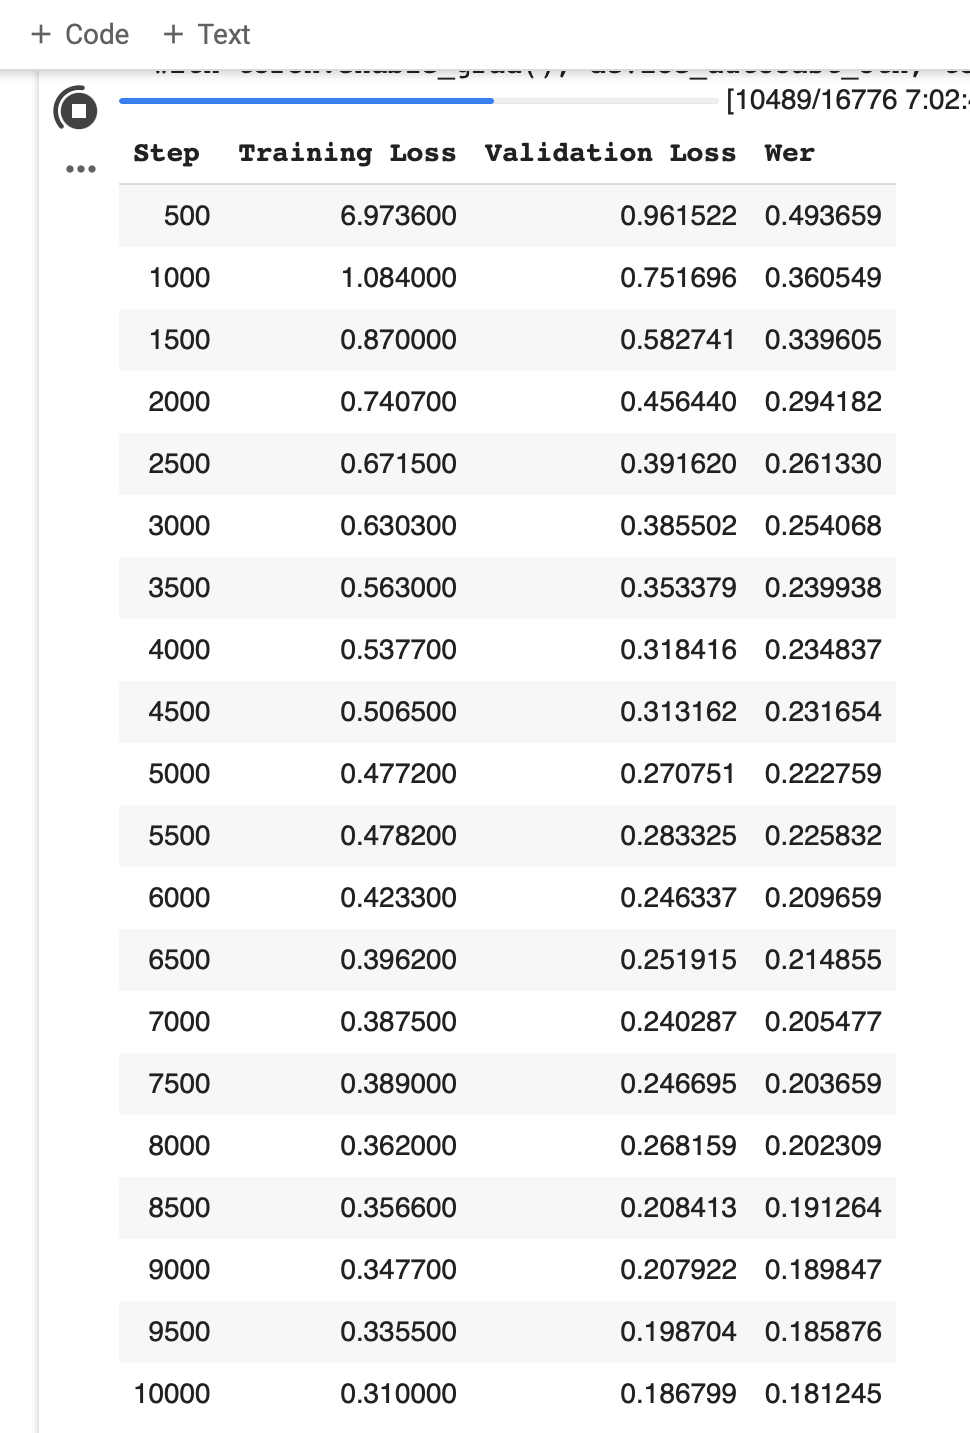

From the training log above, we observed that the training lasted for 7 hours before being interrupted by a disconnection from the Colab machine. A total of 10,000 training steps (with a batch size of 16) were completed. All metrics, including training loss, validation loss, and word error rate (WER), are still gradually decreasing, indicating that the model weights have not yet fully converged; therefore, for the next step, continuing the training from the last checkpoint would be beneficial.

In [38]:
trainer.push_to_hub()

CommitInfo(commit_url='https://huggingface.co/nightraider/wav2vec2-base-cv-demo-google-colab/commit/bdb6d4f0c4d58d0e52dde363d4151c8b835806bb', commit_message='End of training', commit_description='', oid='bdb6d4f0c4d58d0e52dde363d4151c8b835806bb', pr_url=None, pr_revision=None, pr_num=None)

## Evaluation (Task 3c)

Use my finetuned model `wav2vec2-large-960h-cv` for evaluation.

In [39]:
from transformers import AutoModelForCTC, Wav2Vec2Processor

repo_name = "nightraider/wav2vec2-large-960h-cv"
processor = Wav2Vec2Processor.from_pretrained(repo_name)
model = AutoModelForCTC.from_pretrained(repo_name).cuda()

preprocessor_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/331 [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/30.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/96.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/2.09k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Load the evaluation data `cv-valid-test`

In [40]:
cv = load_dataset("nightraider/cv_test", token=True)

Generating test split:   0%|          | 0/3995 [00:00<?, ? examples/s]

In [41]:
cv = cv.remove_columns(['up_votes', 'down_votes', 'age', 'gender', 'accent', 'duration'])

In [42]:
cv = cv.cast_column("audio", Audio(sampling_rate=16000))

In [43]:
cv

DatasetDict({
    test: Dataset({
        features: ['audio', 'text'],
        num_rows: 3995
    })
})

In [44]:
cv = cv.map(remove_special_characters)

Map:   0%|          | 0/3995 [00:00<?, ? examples/s]

In [45]:
def prepare_dataset(batch):
    audio = batch["audio"]

    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    batch["input_length"] = len(batch["input_values"])

    with processor.as_target_processor():
        batch["labels"] = processor(batch["text"]).input_ids
    return batch

In [46]:
cv = cv.map(prepare_dataset, remove_columns=cv.column_names["test"], num_proc=8)

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=8):   0%|          | 0/3995 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:157: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:157: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:157: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call

In [47]:
import torch

def map_to_result(batch):
  with torch.no_grad():
    input_values = torch.tensor(batch["input_values"], device="cuda").unsqueeze(0)
    logits = model(input_values).logits

  pred_ids = torch.argmax(logits, dim=-1)
  batch["pred_str"] = processor.batch_decode(pred_ids)[0]
  batch["text"] = processor.decode(batch["labels"], group_tokens=False)

  return batch

In [48]:
results = cv["test"].map(map_to_result, remove_columns=cv["test"].column_names)

Parameter 'function'=<function map_to_result at 0x7c523f949ea0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/3995 [00:00<?, ? examples/s]

In [49]:
print("Test WER: {:.3f}".format(wer_metric.compute(predictions=results["pred_str"], references=results["text"])))

Test WER: 0.077


In [50]:
show_random_elements(results)

,pred_str,text
0,everything had been written by the same hand,everything has been written by the same hand
1,they set off running wildly into the trees,they set off running wildly into the trees
2,aftern the dictators rule of morty three years or soger the planfey was devostate,after the dictator's rule of fourty three years was over the country was devastated
3,but instead of being saddened he was happy,but instead of being saddened he was happy
4,he must be disguised to avoid encounters with thieves,he must be disguised to avoid encounters with thieves
5,the bar sent me over with it,the boss sent me over with it
6,it's extremely suspicious that there's no information about brains that didn't come from a brain,it's extremely suspicious that there's no information about brains that didn't come from a brain
7,it's like the flight of those two hawks it can't be understood by reason alone,it's like the flight of those two hawks it can't be understood by reason alone
8,looking around he sought his sheep and then realized that he was a new world,looking around he sought his sheep and then realized that he was in a new world
9,the heat lasted until nightfall and all that time he had to carry his jacket,the heat lasted until nightfall and all that time he had to carry his jacket
